# Moving to Prague?

## Introduction

One of the most welcoming destinations for expats in the center of Europe is Prague. And not only because of it's world famous beer, but also for it's vivid social life. If one decides to move to Prague for these reasons, they would need to analyse which district they should choose for living, that would be the most convinient for their needs. And with this comes a difficult decision to make. Therefore an analysis performed with Python would be of great help.  

The analysis presented in this article is based on the Foursquare location data (venues in Prague). And it is main aim it to show which districts in Prague have the most active live in terms of availability of cafes, restaurants, night clubs and so on.

## Data

Import libraries

In [1]:
import pandas as pd
import numpy as np
import geocoder # import geocodera
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

Lets check the coordinates of Prague for the staring point of the map visualization

In [2]:
address = 'Prague, Czech Republic'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Prague are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Prague are 50.0874654, 14.4212535.


Define Foursquare Credentials and Version

In [3]:
CLIENT_ID = 'EAP3OBQIP0O0WAMOTPGLCE0OFDALZ5UNEKI0NGLLQ3VNVNJF' # your Foursquare ID
CLIENT_SECRET = 'K0ZQQIA1AWIMSD2BPK52X2OET2MZOCAFS4UOKLHBIPCWMWV1' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EAP3OBQIP0O0WAMOTPGLCE0OFDALZ5UNEKI0NGLLQ3VNVNJF
CLIENT_SECRET:K0ZQQIA1AWIMSD2BPK52X2OET2MZOCAFS4UOKLHBIPCWMWV1


In [4]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=EAP3OBQIP0O0WAMOTPGLCE0OFDALZ5UNEKI0NGLLQ3VNVNJF&client_secret=K0ZQQIA1AWIMSD2BPK52X2OET2MZOCAFS4UOKLHBIPCWMWV1&v=20180604&ll=50.0874654,14.4212535&radius=500&limit=100'

Let's download Prague Distric data including coordinates

In [5]:
prague_data = pd.read_csv ('Prague_Postal_Codes.csv')
prague_data.head()

,postalCode,District,Latitude,Longitude
0,100 00,Prague 10,50.06763,14.46016
1,100 01,Prague 10,50.06763,14.46016
2,100 02,Prague 10,50.06763,14.46016
3,100 03,Prague 10,50.06763,14.46016
4,100 04,Prague 10,50.06763,14.46016


Let's delete repeated items, and only keep the unique districts

In [6]:
prague = prague_data.drop_duplicates(subset='District', keep='first')
# prague.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
prague.reset_index(drop=True, inplace=True)
prague

,postalCode,District,Latitude,Longitude
0,100 00,Prague 10,50.06763,14.46016
1,110 00,Prague 1,50.08728,14.41742
2,120 00,Prague 2,50.07395,14.43957
3,130 00,Prague 3,50.08261,14.45538
4,140 00,Prague 4,50.04233,14.44812
5,150 00,Prague 5,50.07167,14.40099
6,160 00,Prague 6,50.10106,14.39981
7,170 00,Prague 7,50.10801,14.43797
8,180 00,Prague 8,50.12692,14.45672
9,190 00,Prague 9,50.11059,14.50034


## Exploring Districs in Prague

#### Let's retieve data for all the districts in Prague

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's create a new dataframe.


In [8]:

prague_venues = getNearbyVenues(names=prague['District'],
                                   latitudes=prague['Latitude'],
                                   longitudes=prague['Longitude']
                                  )

Prague 10
Prague 1
Prague 2
Prague 3
Prague 4
Prague 5
Prague 6
Prague 7
Prague 8
Prague 9


Let's check the size of the resulting dataframe


In [9]:
print(prague_venues.shape)
prague_venues

(568, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Prague 10,50.06763,14.46016,Barriqáda,50.068373,14.458013,Wine Bar
1,Prague 10,50.06763,14.46016,Tvoje máma,50.069106,14.458015,Café
2,Prague 10,50.06763,14.46016,Milá tchýně,50.067318,14.457746,Cocktail Bar
3,Prague 10,50.06763,14.46016,Pivní zastávka,50.070652,14.459943,Beer Bar
4,Prague 10,50.06763,14.46016,Antonínovo pekařství,50.068972,14.454778,Bakery
...,...,...,...,...,...,...,...
563,Prague 9,50.11059,14.50034,PC Plus CZ,50.113029,14.501279,Electronics Store
564,Prague 9,50.11059,14.50034,Restaurace Pragovka,50.108589,14.496557,Sports Bar
565,Prague 9,50.11059,14.50034,Skateplaza Na Jetelce,50.113008,14.496351,Plaza
566,Prague 9,50.11059,14.50034,Lanové centrum Proud,50.111068,14.494197,Playground


Let's check how many venues were returned for each neighborhood


In [10]:
prague_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Prague 1,100,100,100,100,100,100
Prague 10,31,31,31,31,31,31
Prague 2,100,100,100,100,100,100
Prague 3,59,59,59,59,59,59
Prague 4,33,33,33,33,33,33
Prague 5,90,90,90,90,90,90
Prague 6,61,61,61,61,61,61
Prague 7,19,19,19,19,19,19
Prague 8,28,28,28,28,28,28


## District Analysis


In [11]:
print('There are {} unique categories.'.format(len(prague_venues['Venue Category'].unique())))

There are 168 unique categories.


In [12]:
# one hot encoding
prague_onehot = pd.get_dummies(prague_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
prague_onehot['Neighborhood'] = prague_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [prague_onehot.columns[-1]] + list(prague_onehot.columns[:-1])
prague_onehot = prague_onehot[fixed_columns]

prague_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Thai Restaurant,Theater,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Prague 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Prague 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Prague 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Prague 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Prague 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
prague_onehot.shape

(568, 169)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [14]:
prague_grouped = prague_onehot.groupby('Neighborhood').mean().reset_index()
prague_grouped

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Thai Restaurant,Theater,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Prague 1,0.000000,0.010000,0.030000,0.01,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.030000,0.000000,0.030000,0.000000,0.010000,0.02,0.010000,0.000000,0.000000
1,Prague 10,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.032258,0.00,...,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.00,0.064516,0.000000,0.000000
2,Prague 2,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.01,...,0.000000,0.010000,0.000000,0.030000,0.000000,0.020000,0.00,0.060000,0.030000,0.030000
3,Prague 3,0.000000,0.000000,0.000000,0.00,0.000000,0.033898,0.016949,0.000000,0.00,...,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,0.00,0.033898,0.000000,0.000000
4,Prague 4,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,0.00,0.000000,0.000000,0.000000
5,Prague 5,0.011111,0.011111,0.011111,0.00,0.011111,0.011111,0.000000,0.000000,0.00,...,0.011111,0.000000,0.011111,0.033333,0.011111,0.033333,0.00,0.000000,0.011111,0.011111
6,Prague 6,0.000000,0.000000,0.000000,0.00,0.000000,0.016393,0.000000,0.000000,0.00,...,0.000000,0.032787,0.000000,0.000000,0.000000,0.049180,0.00,0.016393,0.016393,0.016393
7,Prague 7,0.000000,0.000000,0.052632,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
8,Prague 8,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.035714,0.000000,0.00,...,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.00,0.071429,0.000000,0.000000
9,Prague 9,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.00,0.000000,0.021277,0.000000


Let's confirm the new size


In [15]:
prague_grouped.shape

(10, 169)

Let's print each neighborhood along with the top 5 most common venues


In [16]:
num_top_venues = 5

for hood in prague_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = prague_grouped[prague_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Prague 1----
                venue  freq
0                Café  0.13
1  Italian Restaurant  0.08
2        Cocktail Bar  0.05
3               Plaza  0.04
4          Restaurant  0.04


----Prague 10----
                           venue  freq
0                       Wine Bar  0.06
1                          Plaza  0.06
2                           Café  0.06
3  Vegetarian / Vegan Restaurant  0.06
4                         Bakery  0.06


----Prague 2----
         venue  freq
0         Café  0.11
1          Bar  0.06
2     Wine Bar  0.06
3          Pub  0.04
4  Yoga Studio  0.03


----Prague 3----
              venue  freq
0              Café  0.05
1      Cocktail Bar  0.05
2        Restaurant  0.05
3            Bistro  0.05
4  Asian Restaurant  0.03


----Prague 4----
               venue  freq
0  Electronics Store  0.09
1          Drugstore  0.06
2              Hotel  0.06
3               Café  0.06
4     Clothing Store  0.06


----Prague 5----
            venue  freq
0           Hotel

Let's sort the venues in descending order.

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

The new dataframe to display the top 10 venues for each neighborhood.


In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = prague_grouped['Neighborhood']

for ind in np.arange(prague_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(prague_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Prague 1,Café,Italian Restaurant,Cocktail Bar,Pub,Plaza,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Art Gallery,Theater
1,Prague 10,Wine Bar,Beer Garden,Vegetarian / Vegan Restaurant,Plaza,Bakery,Café,Chinese Restaurant,Pub,Soccer Stadium,Leather Goods Store
2,Prague 2,Café,Wine Bar,Bar,Pub,Yoga Studio,Beer Bar,Bistro,Burger Joint,Cocktail Bar,Wine Shop
3,Prague 3,Restaurant,Bistro,Cocktail Bar,Café,Asian Restaurant,Czech Restaurant,Pub,Hotel,Gym / Fitness Center,Bar
4,Prague 4,Electronics Store,Clothing Store,Hotel,Café,Drugstore,Bakery,Coffee Shop,Mediterranean Restaurant,Fast Food Restaurant,Food & Drink Shop


## Cluster Districts


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [20]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [21]:
max_range = 10

prague_grouped_clustering = prague_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = prague_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

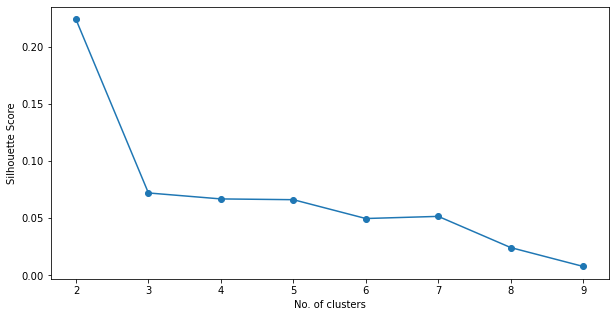

In [22]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

_k_-means is used to cluster the neighborhood into clusters.


In [29]:
# set number of clusters
kclusters = 2

prague_grouped_clustering = prague_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(prague_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [30]:
prague_merged

,postalCode,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,100 00,Prague 10,50.06763,14.46016,0,Wine Bar,Beer Garden,Vegetarian / Vegan Restaurant,Plaza,Bakery,Café,Chinese Restaurant,Pub,Soccer Stadium,Leather Goods Store
1,110 00,Prague 1,50.08728,14.41742,0,Café,Italian Restaurant,Cocktail Bar,Pub,Plaza,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Art Gallery,Theater
2,120 00,Prague 2,50.07395,14.43957,0,Café,Wine Bar,Bar,Pub,Yoga Studio,Beer Bar,Bistro,Burger Joint,Cocktail Bar,Wine Shop
3,130 00,Prague 3,50.08261,14.45538,0,Restaurant,Bistro,Cocktail Bar,Café,Asian Restaurant,Czech Restaurant,Pub,Hotel,Gym / Fitness Center,Bar
4,140 00,Prague 4,50.04233,14.44812,1,Electronics Store,Clothing Store,Hotel,Café,Drugstore,Bakery,Coffee Shop,Mediterranean Restaurant,Fast Food Restaurant,Food & Drink Shop
5,150 00,Prague 5,50.07167,14.40099,1,Hotel,Cosmetics Shop,Pub,Café,Coffee Shop,Clothing Store,Bistro,Park,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
6,160 00,Prague 6,50.10106,14.39981,1,Café,Italian Restaurant,Pub,Bakery,Vietnamese Restaurant,Coffee Shop,Tea Room,Pizza Place,Health Food Store,French Restaurant
7,170 00,Prague 7,50.10801,14.43797,2,Climbing Gym,Bed & Breakfast,Tech Startup,Restaurant,Café,Movie Theater,Spa,Laser Tag,Music Venue,Port
8,180 00,Prague 8,50.12692,14.45672,0,Restaurant,Gastropub,Café,Wine Bar,Bar,Sporting Goods Shop,Park,Chinese Restaurant,Doner Restaurant,Soccer Field
9,190 00,Prague 9,50.11059,14.50034,1,Restaurant,Gastropub,Czech Restaurant,Pharmacy,Clothing Store,Hotel,Coffee Shop,Park,Shoe Store,Electronics Store


In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

prague_merged = prague

# merge prague_grouped with prague_data to add latitude/longitude for each neighborhood
prague_merged = prague_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')

prague_merged.head()

,postalCode,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,100 00,Prague 10,50.06763,14.46016,0,Wine Bar,Beer Garden,Vegetarian / Vegan Restaurant,Plaza,Bakery,Café,Chinese Restaurant,Pub,Soccer Stadium,Leather Goods Store
1,110 00,Prague 1,50.08728,14.41742,0,Café,Italian Restaurant,Cocktail Bar,Pub,Plaza,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Art Gallery,Theater
2,120 00,Prague 2,50.07395,14.43957,0,Café,Wine Bar,Bar,Pub,Yoga Studio,Beer Bar,Bistro,Burger Joint,Cocktail Bar,Wine Shop
3,130 00,Prague 3,50.08261,14.45538,0,Restaurant,Bistro,Cocktail Bar,Café,Asian Restaurant,Czech Restaurant,Pub,Hotel,Gym / Fitness Center,Bar
4,140 00,Prague 4,50.04233,14.44812,1,Electronics Store,Clothing Store,Hotel,Café,Drugstore,Bakery,Coffee Shop,Mediterranean Restaurant,Fast Food Restaurant,Food & Drink Shop


Finally, let's visualize the resulting clusters


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(prague_merged['Latitude'], prague_merged['Longitude'], prague_merged['District'], prague_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='	#808080',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results


The 10 Prague's districts were split into two main clusters (red and purple). 

The red cluster represents districts with the most venues in their vicinity. This also can be explained that the most of activities usually happen in the center of the city.

And the purple cluster represents districts that have less venues and are mostly residential areas. 

#### Cluster 0 - Red

In [34]:
prague_merged.loc[prague_merged['Cluster Labels'] == 0, prague_merged.columns[[1] + list(range(5, prague_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Prague 10,Wine Bar,Beer Garden,Vegetarian / Vegan Restaurant,Plaza,Bakery,Café,Chinese Restaurant,Pub,Soccer Stadium,Leather Goods Store
1,Prague 1,Café,Italian Restaurant,Cocktail Bar,Pub,Plaza,Restaurant,Hotel,Vegetarian / Vegan Restaurant,Art Gallery,Theater
2,Prague 2,Café,Wine Bar,Bar,Pub,Yoga Studio,Beer Bar,Bistro,Burger Joint,Cocktail Bar,Wine Shop
3,Prague 3,Restaurant,Bistro,Cocktail Bar,Café,Asian Restaurant,Czech Restaurant,Pub,Hotel,Gym / Fitness Center,Bar
8,Prague 8,Restaurant,Gastropub,Café,Wine Bar,Bar,Sporting Goods Shop,Park,Chinese Restaurant,Doner Restaurant,Soccer Field


#### Cluster 1 - Purple

In [35]:
prague_merged.loc[prague_merged['Cluster Labels'] == 1, prague_merged.columns[[1] + list(range(5, prague_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Prague 4,Electronics Store,Clothing Store,Hotel,Café,Drugstore,Bakery,Coffee Shop,Mediterranean Restaurant,Fast Food Restaurant,Food & Drink Shop
5,Prague 5,Hotel,Cosmetics Shop,Pub,Café,Coffee Shop,Clothing Store,Bistro,Park,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
6,Prague 6,Café,Italian Restaurant,Pub,Bakery,Vietnamese Restaurant,Coffee Shop,Tea Room,Pizza Place,Health Food Store,French Restaurant
9,Prague 9,Restaurant,Gastropub,Czech Restaurant,Pharmacy,Clothing Store,Hotel,Coffee Shop,Park,Shoe Store,Electronics Store


#### Conclusion

The districts that are marked red can be considered as potential locations  for those who about to move to Prague and is interested to live in an active district with a lot of social events. 